In [1]:
# imports for this notebook 

import numpy as np
from scipy.special import expit
import pandas as pd

from ananke.graphs import ADMG
from ananke.estimation import AverageCausalEffect
from ananke.datasets import helpers

# Semiparametric Inference For Causal Effects

In this section, we discuss how to estimate the effect of treatment $T$ on outcome $Y$ commonly expressed through the use of counterfactuals of the form $Y(t)$ or $Y|\text{do}(t)$ -- which reads as the potential outcome $Y$ had treatment been assigned to $t$. If the outcome is continuous, the effect is typically captured by the average causal effect (ACE) defined as, 

$\psi = E[Y(1)] - E[Y(0)], \quad \text{(when Y is continuous.)}$  

When $Y$ is binary, the effect is typically reported as the log of odds ratios as follows.

$\psi = \log(\frac{p(Y(1) = 1)/p(Y(1) = 0)}{p(Y(0) = 1)/p(Y(0) = 0)}), \quad \text{(when Y is binary.)}$


In Ananke, we consider identification and estimation of these quantities using the language of causal graphs. We illustrate these through a series of examples with increasing levels of complications. The good news is, all the user needs to specify is the data (as a Pandas data frame) and a story for what they believe the world looks like in the form of an acyclic directed mixed graph (ADMG) where each bidirected edge encodes unmeasured common confounders. Ananke will then provide suggestions for the best estimator given the graphical story provided by the user. If it is not possible to compute the ACE given this story (i.e., the quantity is not _identified_) then Ananke will also inform the user if this is the case.

Let's say we are studying the efficacy of a new antiretroviral therapy vs. an old one. Call this the treatment $T$ where $T=1$ represents receiving the new drug and $T=0$ represents receiving the old. Our outcome of interest is the patients CD4 counts post treatment.


## Estimation via Adjustment

As a first pass, an analyst might check the causal effect under the causal graphical model where all common confounders of the treatment and outcome are measured. A highly simplistic story would be as follows. The initial viral load of the patient affects both which treatment the patient is assigned to as well as their final outcome. This is represented graphically as follows. Just be careful not to have spaces in your variable names, the machine learning packages underlying Ananke are not compatible with that.

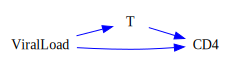

In [2]:
vertices = ['ViralLoad', 'T', 'CD4']
di_edges = [('ViralLoad', 'T'), ('ViralLoad', 'CD4'), ('T', 'CD4')]
G = ADMG(vertices, di_edges)
G.draw(direction="LR")

We now load some toy data on these three variables, and ask Ananke to estimate the effect. We see that as soon as we instantiate the `AverageCausalEffect` object, Ananke offers recommendations for what strategy to use to estimate the causal effect under the specified causal graph. In this case, it recommends _Efficient Generalized AIPW_ which is to say, that the estimator used to compute the effect in this case looks a lot like Augmented IPW and further, Ananke uses semiparametric theory in order to provide an estimate that has the lowest asymptotic variance i.e., the estimator is efficient. Turns out, the efficient estimator in this case is trivial, but the next case demonstrates a harder scenario.

In [3]:
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
data = helpers.load_conditionally_ignorable_data()
ace, Ql, Qu = ace_obj.bootstrap_ace(data, "eff-aipw", n_bootstraps=1)
print(ace)


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 

0.9848858526281855


A realistic model will rarely be so simple. So what if we want to build a more complicated model such as the one shown below. Where, bidirected edges ($\leftrightarrow$) are used to encode unmeasured common confounders. For example, we hypothesize that we do not have information on some unmeasured common confounders between an individual's income and treatment assignment for example.

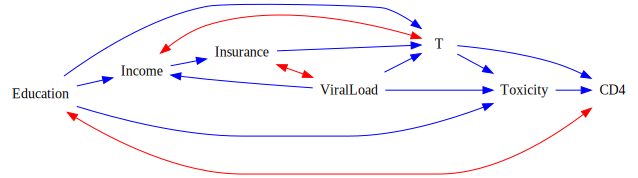

In [14]:
vertices = ['Income', 'Insurance', 'ViralLoad', 'Education', 'T', 'Toxicity', 'CD4']
di_edges = [('ViralLoad', 'Income'), ('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'),
            ('Education', 'Income'), ('Education', 'T'), ('Education', 'Toxicity'),
            ('Income', 'Insurance'), ('Insurance', 'T'), ('T', 'Toxicity'), ('Toxicity', 'CD4'), ('T', 'CD4')]
bi_edges = [('Income', 'T'), ('Insurance', 'ViralLoad'), ('Education', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

In [5]:
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
data = helpers.load_afixable_data() # load some pre-simulated data
ace, _, _ = ace_obj.bootstrap_ace(data, "eff-aipw", n_bootstraps=1)
print(ace)


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 

0.4917151858667248


## Estimation beyond Adjustment

The previous examples showed that there exists a large class of causal graphs for which we can obtain the causal effect via covariate adjustment. But what happens when covariate adjustment fails? It turns out, that there is an even wider class of models for which we can obtain the causal effect, _even_ when we cannot block all backdoor paths from the treatment to the outcome. Revisiting our running example on antiretroviral therapies. Let us first see an example where the causal effect is not (non-parametrically) identified from the observed data.

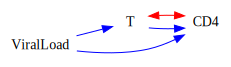

In [6]:
vertices = ['ViralLoad', 'T', 'CD4']
di_edges = [('ViralLoad', 'T'), ('ViralLoad', 'CD4'), ('T', 'CD4')]
bi_edges = [('T', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

You will notice that this differs ever so slightly yet crucially from our first example in that we as analysts now believe that there are unmeasured confounders between the treatment (T) and the outcome (CD4). If we ask Ananke to estimate the causal effect under this model of the world, it will declare (correctly) that the effect is not identified non-parametrically under the given model.

In [7]:
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object

Effect is not identified! 



So what can we do then? Well, if we believe another model wherein the effect of the treatment is mediated completely through some biologically known mechanism whose by-product we can measure. Say this occurs through a reduction in viral load, and that it addition to a baseline measurement we have a second follow-up measurement.

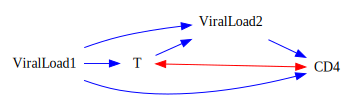

In [8]:
vertices = ['ViralLoad1', 'T', 'ViralLoad2', 'CD4']
di_edges = [('ViralLoad1', 'T'), ('ViralLoad1', 'CD4'), ('ViralLoad1', 'ViralLoad2'),
            ('T', 'ViralLoad2'), ('ViralLoad2', 'CD4')]
bi_edges = [('T', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

It so happens that this is quite similar to the front-door graph that may be familiar to some users, and the effect is now identified! Here is how we can estimate it using Ananke.

In [9]:
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
data = helpers.load_frontdoor_data()
ace, _, _ = ace_obj.bootstrap_ace(data, "eff-apipw", n_bootstraps=1)
print(ace)


 Treatment is p-fixable and graph is mb-shielded. 

 Available estimators are:
1. Primal IPW (p-ipw)
2. Dual IPW (d-ipw)
3. APIPW (apipw)
4. Efficient APIPW (eff-apipw) 
 
Suggested estimator is Efficient APIPW 

-0.7813625198154697


## Useful Graphical Criteria

In the previous section, we have seen that causal effects are not always identified, and if they are, they could be identified and estimated in different ways. Here we provide some simple graphical criteria that a user should keep in mind while creating their graphical model that may help guide them to obtain the best estimator possible. These graphical criteria and their corresponding estimators can be found in our work [Semiparametric Inference For Causal Effects In Graphical Models With Hidden Variables](https://arxiv.org/pdf/2003.12659.pdf).

### Adjustment Fixability

If the treatment of interest (say $T$) has no bidirected path to any of its descendants (i.e., there is no $T \leftrightarrow \cdots \leftrightarrow X$ for any $X$ that is a descendant of $T$), then we say the treatment is adjustment or a-fixable. In this case, Ananke will find estimators that are based on IPW and covariate adjustment as well as a semiparametric estimator that has the form of **Augmented IPW**. Ananke will always recommend **Generalized AIPW** as the preferred estimator due to its double robustness property. Further, if the graph satisfies a property known as the mb-shielded (Markov blanket shielded) property, Ananke will be able to provide the most **efficient influence function** based estimator -- one that achieves the semiparametric efficiency bound, and recommend using this instead when possible. Below is an example of a causal graph where the treatment is a-fixable and the graph is mb-shielded.


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



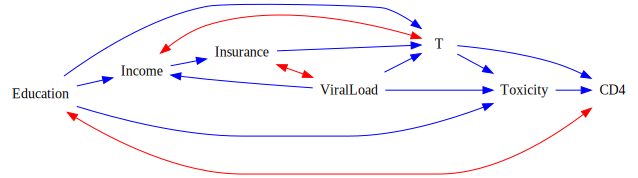

In [10]:
vertices = ['Income', 'Insurance', 'ViralLoad', 'Education', 'T', 'Toxicity', 'CD4']
di_edges = [('ViralLoad', 'Income'), ('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'),
            ('Education', 'Income'), ('Education', 'T'), ('Education', 'Toxicity'),
            ('Income', 'Insurance'), ('Insurance', 'T'), ('T', 'Toxicity'), ('Toxicity', 'CD4'), ('T', 'CD4')]
bi_edges = [('Income', 'T'), ('Insurance', 'ViralLoad'), ('Education', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
G.draw(direction="LR")

### Primal Fixability

If the treatment of interest (say $T$) has no bidirected path to any of its **children** (i.e., there is no $T \leftrightarrow \cdots \leftrightarrow X$ for any $X$ that is a child of $T$), then we say the treatment is primal or p-fixable. Notice that due to the graphical criterion being related to children as opposed to all descendants, p-fixability is strictly more general than a-fixability. Further, p-fixability covers many important and popular classes of causal graphs such as the front-door graph.

When $T$ is p-fixable, Ananke finds estimators based on Primal IPW, Dual IPW, and **Augmented Primal IPW**. Ananke will always recommend Augmented Primal IPW as the preferred estimator. As before, when the graph is mb-shielded, Ananke is also able to provide the efficient influence function based estimator and will instead recommend **Efficient Augmented Primal IPW**. Below is an example of an mb-shielded graph where $T$ is p-fixable.


 Treatment is p-fixable and graph is mb-shielded. 

 Available estimators are:
1. Primal IPW (p-ipw)
2. Dual IPW (d-ipw)
3. APIPW (apipw)
4. Efficient APIPW (eff-apipw) 
 
Suggested estimator is Efficient APIPW 



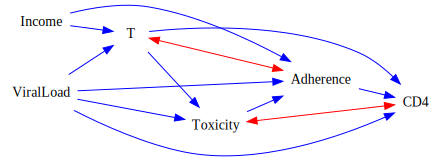

In [11]:
vertices = ['ViralLoad', 'Income', 'T', 'Toxicity', 'Adherence', 'CD4']
di_edges = [('ViralLoad', 'T'), ('ViralLoad', 'Toxicity'), ('ViralLoad', 'Adherence'), ('ViralLoad', 'CD4'),
            ('Income', 'T'), ('Income', 'Adherence'),
            ('T', 'Toxicity'), ('Toxicity', 'Adherence'), ('Adherence', 'CD4'), ('T', 'CD4')]
bi_edges = [('T', 'Adherence'), ('Toxicity', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
G.draw(direction="LR")

### Nested Fixability

Finally, this if the treatment is neither a-fixable nor p-fixable, Ananke checks if it is what we call nested fixable. That is, the treatment is nested fixable if running Algorithm 2 in our [paper](https://arxiv.org/pdf/2003.12659.pdf) succeeds in finding an estimator. Ananke will then allow the user to use either Nested IPW or **Augmented Nested IPW** but its recommendation will be the latter. Below is an example.


 Effect is identified. 
 
 Available estimators:
1. Nested IPW (n-ipw)
2. Augmented NIPW (anipw) 

Suggested estimator is Augmented NIPW 



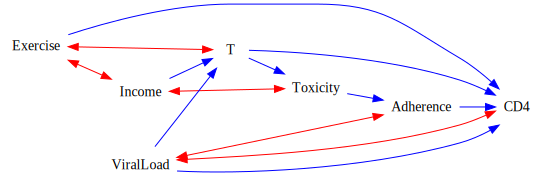

In [12]:
vertices = ['Income', 'Exercise', 'T', 'Toxicity', 'Adherence', 'CD4', 'ViralLoad']
di_edges = [('ViralLoad', 'T'), ('ViralLoad', 'CD4'), ('Income', 'T'), ('Exercise', 'CD4'),
            ('T', 'Toxicity'), ('T', 'CD4'), ('Toxicity', 'Adherence'), ('Adherence', 'CD4')]
bi_edges = [('Income', 'Toxicity'), ('Exercise', 'Income'), ('Exercise', 'T'),
            ('ViralLoad', 'Adherence'), ('ViralLoad', 'CD4')]
G = ADMG(vertices, di_edges, bi_edges)
ace_obj = AverageCausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the ACE object
G.draw(direction="LR")

Note that naturally the class of models that satisfy a-fixability, p-fixability and nested fixability are subsets of each other. That is,

$$\text{adjustment fixability} \subset \text{primal fixability} \subset \text{nested fixability}.$$

Thus, if the user wanted to use Nested IPW for a-fixable graphs, Ananke would not stop you. However, the reverse will result in an error from Ananke. Further, if the effect is not identified, Ananke will not allow the user to use any of the estimators.